# TFG "Entrenamiento de Redes Convolucionales mediante la Transformada de Fourier"
* Autora: Isabel María Moreno Cuadrado


A  continuación se presentan una serie de experimentos  realizados para evaluar la viabilidad del nuevo método de convolución convolution\_fft en problemas de VC.  Adicionalmente, a través de estos experimentos se pone de manifiesto la utilidad de esta operación en aplicaciones más allá del DL.

In [ ]:
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**IMPORTANTE**

CAMBIAR LA RUTA A LA CARPETA EN LA QUE SE TENGAN LAS IMÁGENES ALMACENADAS.

In [ ]:
# We import the modules to use
import os,sys
import cv2, numpy as np, math
from matplotlib import pyplot as plt
# change directory
%cd '/content/drive/My Drive'
#  the current directory
%pwd

# This allows to display images  and to save  them in cells
%matplotlib inline
# this definition allows to read files in a specific path
get_image = lambda route: os.path.join('/content/drive/My Drive/images', route)  #IMPORTANTE CAMBIAR LA RUTA DONDE SE TENGAN LAS IMÁGENES ALMACENADAS

/content/drive/My Drive


Se discretizan las funciones Gaussianas como se comentó en la primera parte del TFG para obtener núcleos gaussianos.

In [ ]:
# Función Gaussiana
def GaussFunc(x, sigma):
    return np.exp(-x**2 / (2 * sigma**2))

# Primera derivada de la función Gaussiana
def GaussDeriv1Func(x, sigma):
    return np.exp(-x**2 / (2 * sigma**2)) * (-x / (sigma**2))*sigma

# Segunda derivada de la función Gaussiana
def GaussDeriv2Func(x, sigma):
    return ((x**2 - sigma**2) / (sigma**4)) * np.exp(-x**2 / (2 * sigma**2))*(sigma**2)

# Función para crear y mostrar la máscara Gaussiana 1D
def gaussianMask1D(sigma=0, sizeMask=0, order=0):
    # Calcular sigma y sizeMask si no se proporcionan
    if sizeMask == 0:
        sizeMask = 2 * int(3 * sigma) + 1
    if sigma == 0:
        sigma = (sizeMask - 1) / 6.0

    k = int(3 * sigma)  # Parámetro k
    mask = np.zeros(sizeMask)  # Inicializar la máscara
    suma = 0  # Variable para normalizar la máscara

    # Calcular la máscara según el orden especificado
    if order == 0:
        for i in range(-k, k + 1):
            f_x = GaussFunc(i, sigma)
            mask[i + k] = f_x
            suma += f_x
        mask /= suma  # Normalizar la máscara

    elif order == 1:
        for i in range(-k, k + 1):
            mask[i + k] = GaussDeriv1Func(i, sigma)

    elif order == 2:
        for i in range(-k, k + 1):
            mask[i + k] = GaussDeriv2Func(i, sigma)

    return mask

# DEFINIMOS EL NUEVO MÉTODO DE CONVOLUCIÓN

A continuación se detalla el algoritmo de convolución `convolucion_fft` propuesto, el cual emplea el Teorema de Convolución.



1. Transformar la imagen $n \times n$ y el *kernel* $k \times k$ al dominio de Fourier utilizando la FFT. Para ello, el *kernel*, que generalmente es mucho más pequeño que la imagen, se ajusta al mismo tamaño que esta. En general, para evitar propiedades de envolvimiento no deseadas, se redimensionan ambos operandos a un tamaño $N > n + k - 1$, que suele ser potencia de dos para aprovechar las propiedades del algoritmo FFT en este caso.
2. Realizar el producto punto a punto de las transformadas.
3. Transformar el resultado de vuelta al dominio espacial utilizando la IDFT. Para ello se deberá reajustar la salida al tamaño deseado.

También se presenta una implementación en términos de gpu`convolucion_fft_gpu`


In [ ]:
import scipy.signal
import cv2
import tensorflow as tf
import signal
import time
import numpy as np


# Función de convolución usando FFT en modo 'same'
def convolution_fft(image, kernel):
    H, W = image.shape
    kH, kW = kernel.shape

    # Calcular el tamaño de la FFT añadiendo el padding necesario
    fftsize = (2**int(np.ceil(np.log2(H + kH - 1))), 2**int(np.ceil(np.log2(W + kW - 1))))

    # Añadir padding a la imagen
    padded_image = np.pad(image, ((0, kH - 1), (0, kW - 1)), mode='constant')

    # Realizar la FFT de la imagen y el kernel
    image_fft = np.fft.fft2(padded_image, fftsize)
    kernel_fft = np.fft.fft2(kernel, fftsize)

    # Multiplicar las FFTs
    result_fft = image_fft * kernel_fft

    # Inversa de la FFT para obtener el resultado convolucionado
    result_inversa = np.fft.ifft2(result_fft)

    # Tomar la parte real del resultado
    result_inversa = np.real(result_inversa)

    # Recortar para obtener el tamaño original de la imagen
    result_central = result_inversa[kH // 2: kH // 2 + H, kW // 2: kW // 2 + W]

    return result_central

def convolution_fft_gpu(image, kernel):
    H, W = image.shape
    hs = kernel.shape[0] // 2

    # Calcula el tamaño de relleno en función de la potencia de 2 más cercana a las dimensiones originales
    #fftsize = max(2**int(np.ceil(np.log2(H + hs))), 2**int(np.ceil(np.log2(W + hs))))
    fftsize = 2**int(np.ceil(np.log2(max(H, W) + hs)))

     # Ajustar la forma del kernel para que coincida con la forma (fftsize,fftsize)
    kernel_shape = tf.shape(kernel)
    padded_kernel = tf.pad(kernel, [(0, fftsize - kernel_shape[0]), (0, fftsize - kernel_shape[1])])
    kernel_fft = tf.signal.fft2d(tf.cast(padded_kernel, tf.complex64))

    # Ajustar la forma de la imagen para que coincida con la forma (fftsize,fftsize)
    image_shape = tf.shape(image)
    padded_image = tf.pad(image, [(0, fftsize - image_shape[0]), (0, fftsize - image_shape[1])])
    image_fft = tf.signal.fft2d(tf.cast(padded_image, tf.complex64))

    # Realiza la multiplicación en el dominio de la frecuencia
    result_fft = image_fft * kernel_fft

    # Aplica la Transformada Inversa de Fourier para obtener la convolución
    result_inversa = tf.signal.ifft2d(result_fft)

    # Aplica el recorte para eliminar el relleno
    result_inversa = result_inversa[hs:hs+H, hs:hs+W]


    return tf.math.real(result_inversa).numpy()


In [ ]:
'''
Código de la asignatura VC
'''
def my2DConv(im, sigma, orders):
    ddepth = cv2.CV_64F
    maskG = gaussianMask1D(sigma, order=0)
    maskDG = gaussianMask1D(sigma, order=1)
    mask2DG = gaussianMask1D(sigma, order=2)

    # Construimos un núcleo gaussiano 2D
    matriz_resultante = np.outer(maskG, maskG)
    return convolution_fft(im,matriz_resultante) #Puede intercambiar por la convolución en la gpu

In [79]:
'''
Código de la asignatura VC
'''
def displayIm(im, title='Result', factor=2, fontsize=20):
    # First normalize range
    max_val = np.max(im)
    min_val = np.min(im)
    if min_val < 0 or max_val > 255:
        im = rangeDisplay01(im, flag_GLOBAL=True)
    if len(im.shape) == 3:
        # im has three-channels
        plt.imshow(im, cmap='jet')
    else:
        # im has a single-channel
        plt.imshow(im, cmap='gray')
    figure_size = plt.gcf().get_size_inches()
    plt.gcf().set_size_inches(factor * figure_size)
    plt.title(title, fontsize=fontsize)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
'''
Código de la asignatura VC
'''
def displayPyramid(vim, title='result'):
  temp = np.zeros_like(vim[0])
  if np.mod(temp.shape[1],2)==0:
    h = temp[:, :temp.shape[1]//2]
  else:
    h = temp[:, :(temp.shape[1]//2)+1]
  out = np.hstack((temp, h))
  top = 0
  out[0:vim[0].shape[0], 0:vim[0].shape[1]] = vim[0]
  left = vim[0].shape[1]
  for i in range(1, len(vim)):
    out[top:top+vim[i].shape[0], left:left + vim[i].shape[1]] = vim[i]
    top += vim[i].shape[0]
  displayIm(out, title)

In [ ]:
'''
Código de la asignatura VC
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

# Pirámide Gaussiana

Se plantea construir una pirámide Gaussiana, una técnica crucial en el procesamiento de imágenes y visión por computador (VC) que se utiliza para representar una imagen en múltiples escalas de resolución. La pirámide Gaussiana es ampliamente utilizada en aplicaciones de procesamiento de imágenes, como la detección de características, el análisis multi-resolución y la compresión de imágenes, debido a su capacidad para preservar la información relevante de la imagen a diferentes niveles de detalle.

  El mecanismo de construcción de la pirámide Gaussiana consta de dos etapas: una de suavizado (en la que se utiliza el algoritmo de convolución) y otra de reducción de dimensión.

  En la parte de suavizado, se utiliza la convolución descrita con un filtro Gaussiano, lo cual permite suavizar la imagen eliminando detalles finos y ruido. Posteriormente, en la etapa de reducción de dimensión, la imagen suavizada se recorta, típicamente eliminando filas y columnas pares o mediante una función de redimensionado, reduciendo así la resolución de la imagen.

  Este proceso se realiza de manera iterativa hasta alcanzar el número de niveles deseado en la pirámide. La importancia del suavizado para reducir la dimensionalidad es notoria; al recortar la imagen sin suavizar, aparece ruido y distorsión en la misma, lo cual se evita mediante el suavizado. De esta manera, se obtiene una versión suavizada de la imagen a distintas escalas, permitiendo una representación jerárquica y multi-resolución de la misma. Al suavizar y reducir la imagen, se preserva la información global mientras se eliminan detalles finos.


Veamos el ejemplo de una Pirámide Gaussiana:

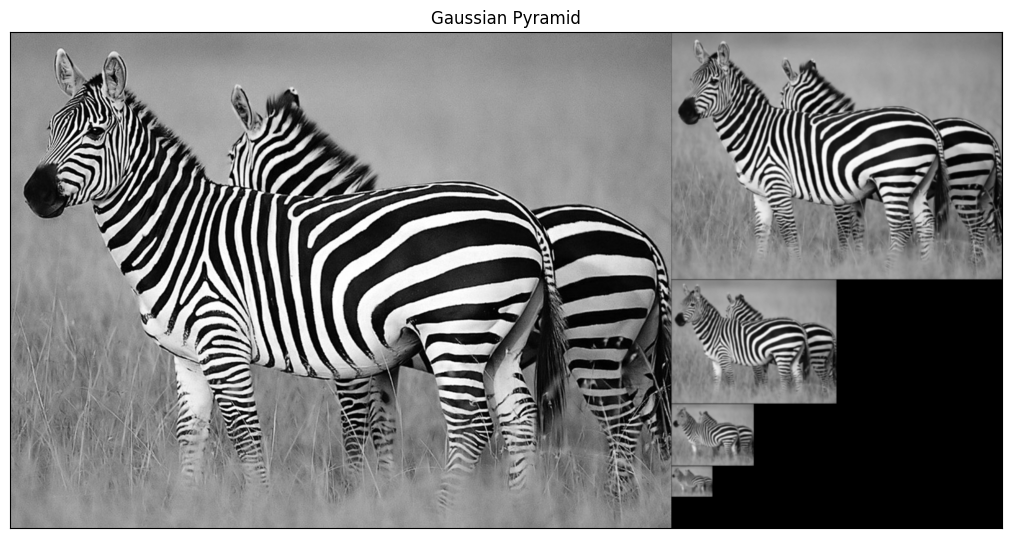

In [ ]:
def recortar (im1):
  #im = im1[1::2, 1::2]  # Selecciona filas e columnas impares
  #im = cv2.resize(im1, None, fx=1/2, fy=1/2, interpolation=cv2.INTER_LINEAR)
  im = cv2.resize(im1,(im1.shape[1]//2,im1.shape[0]//2),cv2.INTER_LINEAR)
  return im

def pyramidGauss(im,sizeMask=7, nlevel=4):
  vim=[im]
  sigma = 3.0
  for i in range (1,nlevel+1):
    imagen_suavizada = my2DConv(vim[i-1],sigma,[0,0])
    imagen = recortar(imagen_suavizada)
    vim.append(imagen)
  return vim

im=cv2.imread(get_image('zebra.jpg'),0)
pyrG = pyramidGauss(im,sizeMask=7, nlevel=4)
displayPyramid(pyrG,'Gaussian Pyramid')

# Pirámide Laplaciana

Se pide construir una pirámide Laplaciana, que se calcula a partir de la Gaussiana. La pirámide Laplaciana destaca los detalles de alta frecuencia en cada nivel, lo cual es útil para aplicaciones que requieren detectar y representar características finas.

  El proceso es el siguiente: Se parte de la imagen más pequeña producida por la Pirámide Gaussiana (ya que la Gaussiana detecta los detalles gruesos, la diferencia calcula los detalles finos de esta), se expande y se calcula la diferencia con el siguiente nivel de la Gaussiana. Este proceso se repite de manera iterativa y estas diferencias van constituyendo la pirámide Laplaciana, a la que luego se le debe dar la vuelta, ya que a diferencia de la Gaussiana, esta es construida de menor a mayor tamaño. A continuación de muestra el ejemplo de una Pirámide Laplaciana:


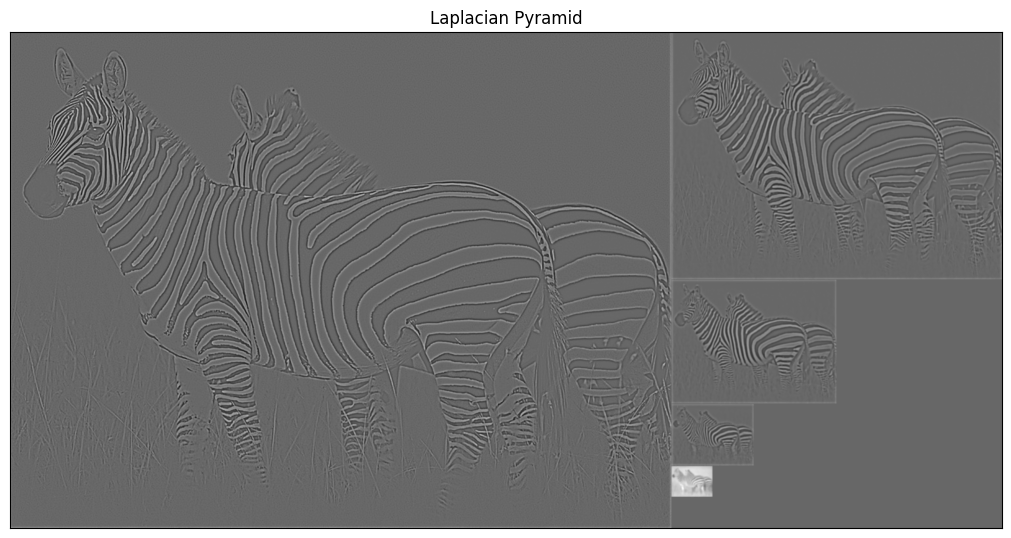

In [ ]:
def expandir(im1,target_height, target_width):
    # Redimensiona la imagen al doble de tamaño
    #im = cv2.resize(im1, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    im = cv2.resize(im1,(target_width,target_height),cv2.INTER_LINEAR)
    return im

def pyramidLap(im, sizeMask, nlevel=4, flagInterp=cv2.INTER_LINEAR):
    # Genera la pirámide Gaussiana
    vim = pyramidGauss(im, sizeMask=sizeMask, nlevel=nlevel)
    vimL = []
    # Añade la última imagen de la pirámide Gaussiana a la pirámide Laplaciana
    vimL.append(vim[nlevel])
    for i in range(1, nlevel+1):
        imagen_expandida = expandir(vim[(nlevel+1)-i],vim[nlevel-i].shape[0],vim[nlevel-i].shape[1])
        imagen_nueva  = vim[nlevel-i] - imagen_expandida
        vimL.append(imagen_nueva)
    vimL.reverse()
    return vimL

# Resto del código
im = cv2.imread(get_image('zebra.jpg'), 0)
pyrL = pyramidLap(im, sizeMask=7, nlevel=4)
displayPyramid(pyrL, 'Laplacian Pyramid')

A diferencia de la pirámide Gaussiana, en la pirámide Laplaciana se almacenan los detalles finos a cada nivel, así como los bordes y las texturas de la imagen. A partir de la pirámide Laplaciana, si esta se ha construido correctamente, se puede recuperar **exactamente** la imagen original. Este proceso parte de la imagen de menor dimensión en la pirámide Laplaciana. Esta imagen se aumenta hasta que coincida con las dimensiones de la imagen Laplaciana del siguiente nivel superior. A continuación, se suman ambas imágenes. Este procedimiento se repite iterativamente, subiendo de nivel, hasta que se alcanza y suma la imagen del último nivel de la pirámide Laplaciana. Al final, se obtiene la imagen original.


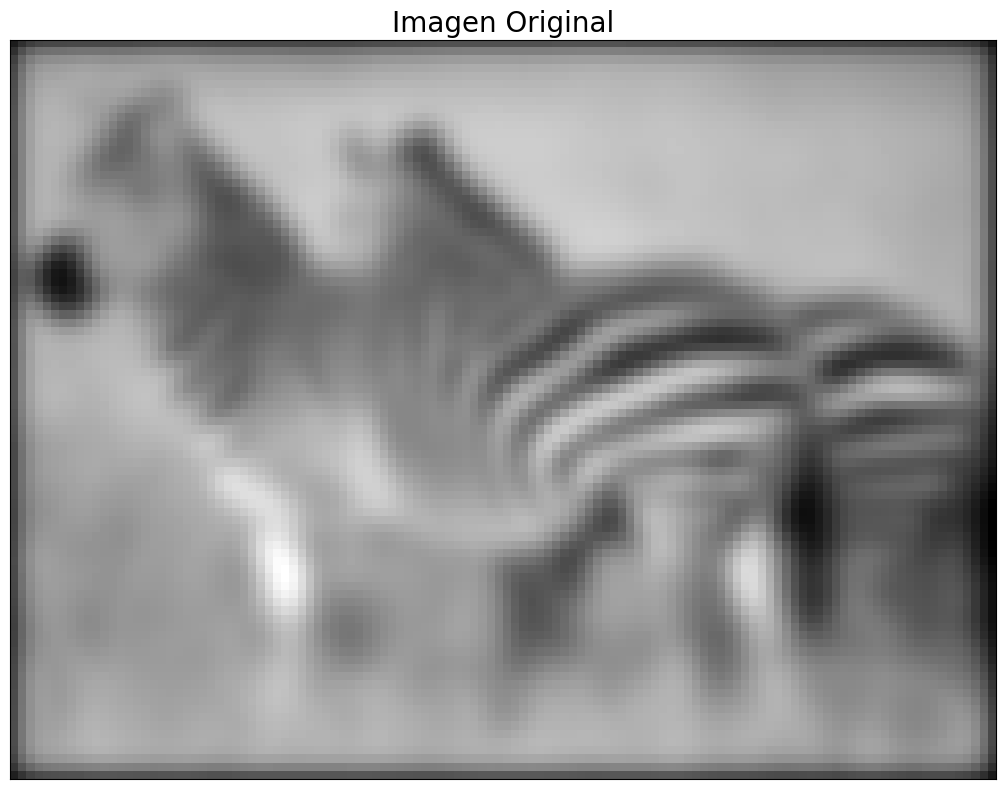

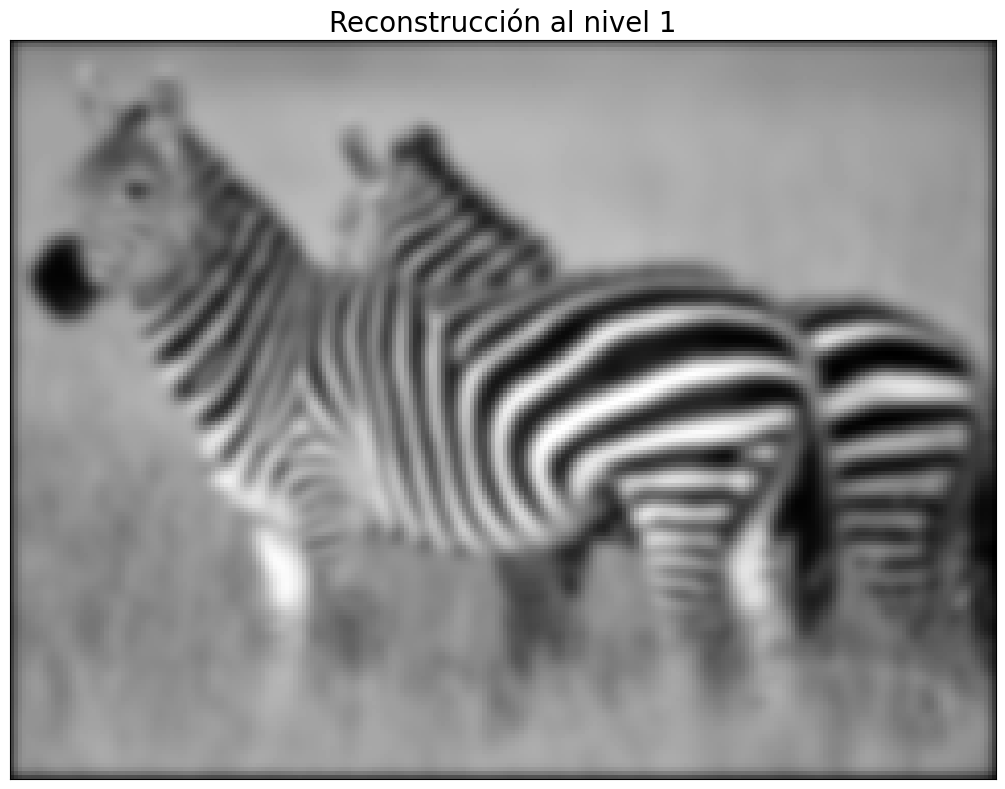

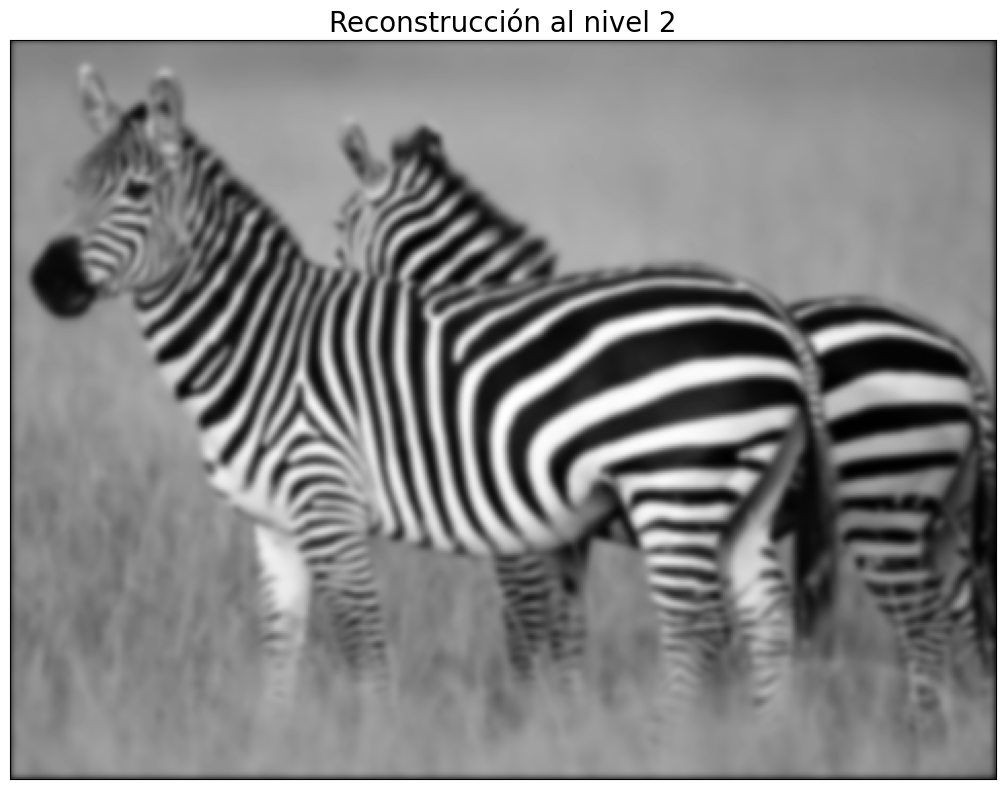

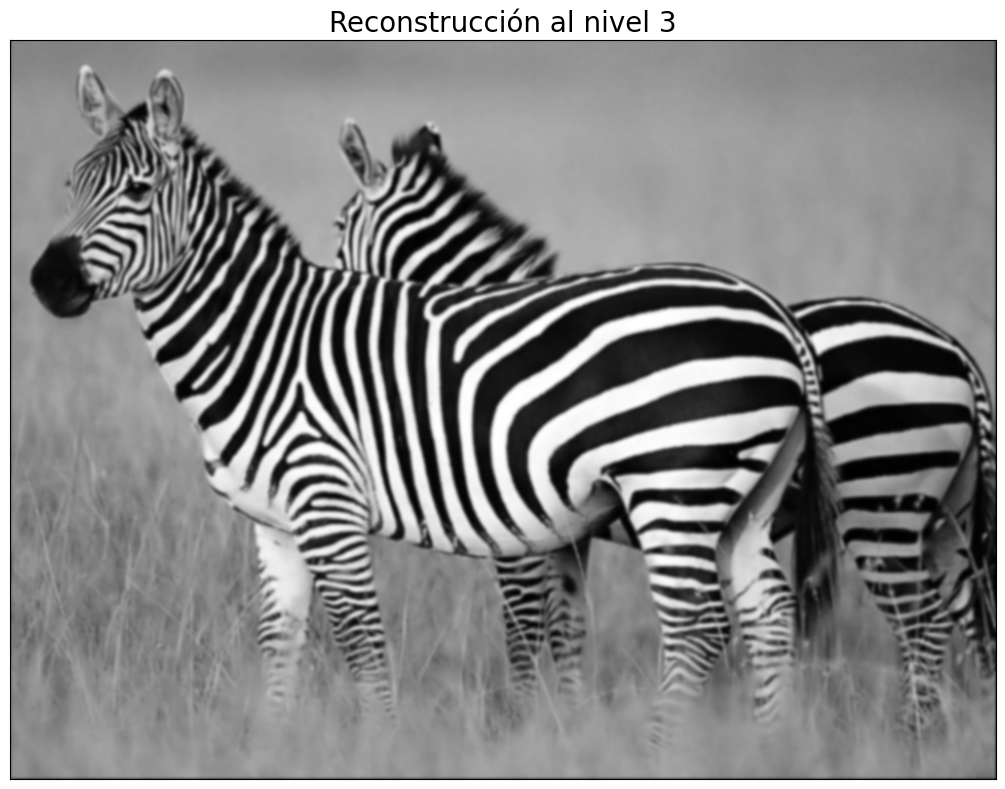

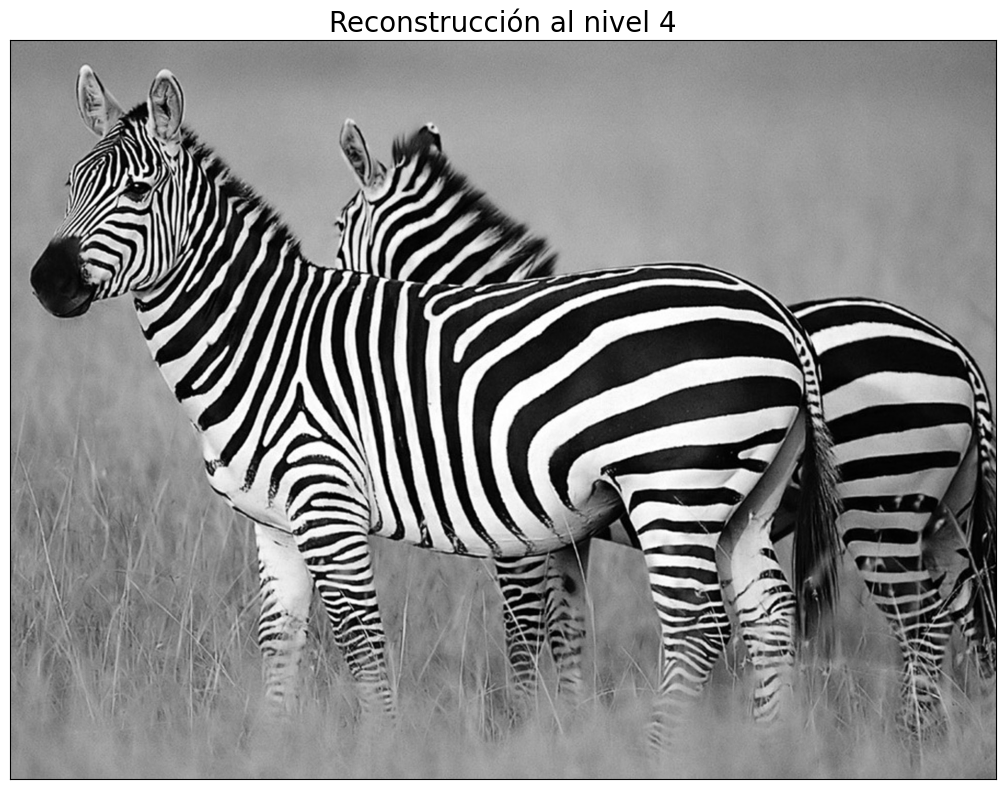

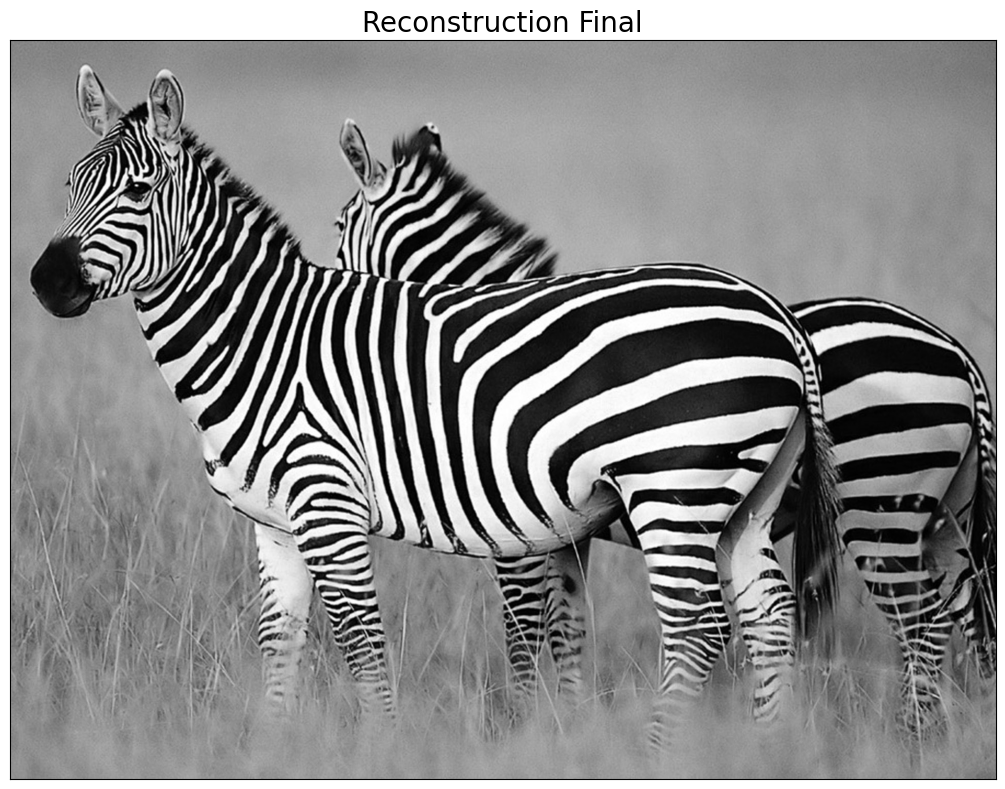

Error per pixel 0.0


In [81]:
def reconstructLap(pyL, flagInterp):
    # Iniciar con la imagen más pequeña de la pirámide Laplaciana
    reconstructed_image = pyL[-1]

    # Imprimir la imagen original
    displayIm(reconstructed_image, 'Imagen Original')

    # Iterar a través de los niveles de la pirámide en orden inverso
    for i in range(1, len(pyL)):
      expanded_level = cv2.resize(reconstructed_image, (pyL[len(pyL)-i-1].shape[1], pyL[len(pyL)-i-1].shape[0]), interpolation=flagInterp)
      reconstructed_image = pyL[len(pyL)-i-1] + expanded_level
      # Imprimir la reconstrucción en este nivel
      displayIm(reconstructed_image, f'Reconstrucción al nivel {i}')
    # Imprimir la reconstrucción final
    displayIm(reconstructed_image, 'Reconstruction Final')
    return reconstructed_image

#A COMPLETAR POR EL ALUMNADO
sizeMask = 10 #¿?¿?¿
reconstructed_image = reconstructLap(pyramidLap(im, sizeMask), cv2.INTER_LINEAR)
print('Error per pixel', np.sqrt(np.linalg.norm(im - np.round(reconstructed_image), ord=2) / np.prod(im.shape)))

Este método no solo es una técnica eficaz para la reconstrucción de imágenes, sino que también proporciona una manera de comprobar la precisión y efectividad de nuestro método de convolución. Si la imagen original se puede reconstruir con exactitud a partir de la pirámide Laplaciana, esto indica que nuestro método de convolución ha funcionado de manera precisa y efectiva en cada etapa de la descomposición y posterior reconstrucción de la imagen. Este enfoque abre un abanico de posibilidades, donde en ocasiones resulta más ventajoso tener almacenadas, en lugar de la imagen original, las "piezas" necesarias para poder reconstruirla.


# IMÁGENES HÍBRIDAS


Este ejercicio se basa en el trabajo de Aude Oliva, Antonio Torralba y Philippe. G. Schyns.
El objetivo de este es aprender cómo el sistema visual humano extrae información sobre un objeto en función de la distancia. Para ello, se construye una imagen híbrida a partir de dos imágenes de objetos diferentes. Mezclando adecuadamente parte de las altas frecuencias de una imagen con parte de las bajas frecuencias de otra imagen, se obtiene una imagen híbrida que muestra diferentes percepciones con la distancia. El $\sigma$ empleado para filtrar ambas imágenes (tanto la de alta como la de bajas frecuencias) es el aspecto clave para seleccionar el rango de frecuencias altas y bajas de cada imagen. Cuanto mayor sea el valor $\sigma$, mayor será la eliminación de altas frecuencias de la imagen.

Es también importante elegir la imagen cuyas altas frecuencias se van a calcular (que será aquella  que tenga originalmente los bordes más marcados) y la imagen cuyas bajas frecuencias se vayan a calcular. Para obtener un buen resultado, es crucial disponer de una función de convolución correctamente implementada, ya que esta se utiliza para extraer tanto las altas como las bajas frecuencias de las imágenes.

Este es un ejercicio delicado, donde cualquier desfase o desplazamiento producido en la imagen puede afectar negativamente a la imagen final.



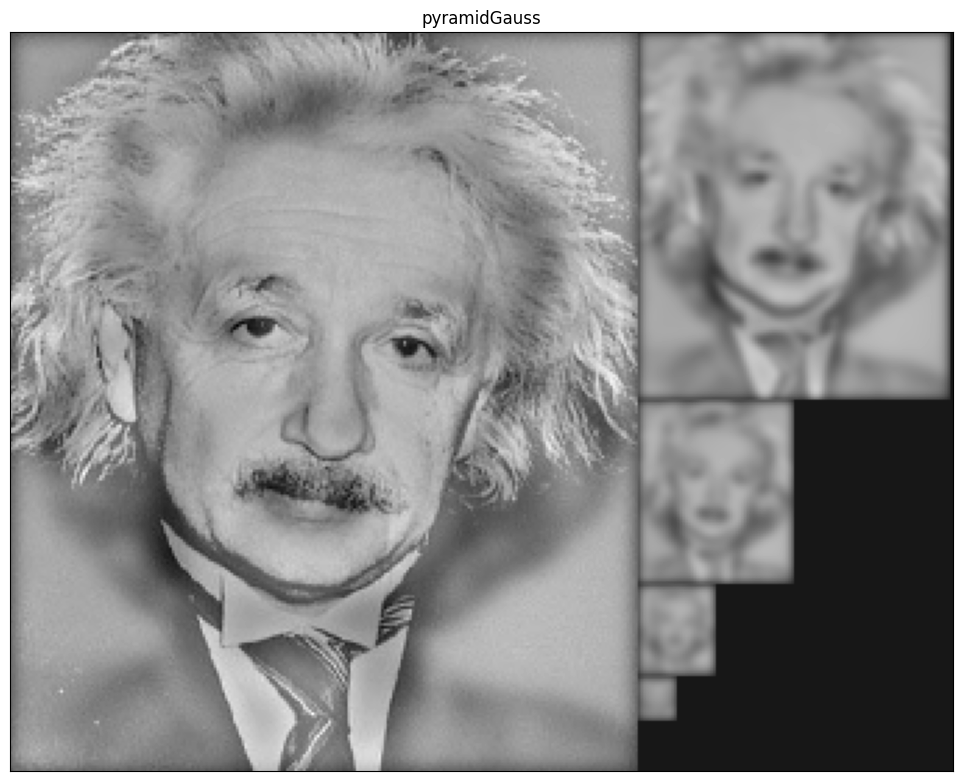

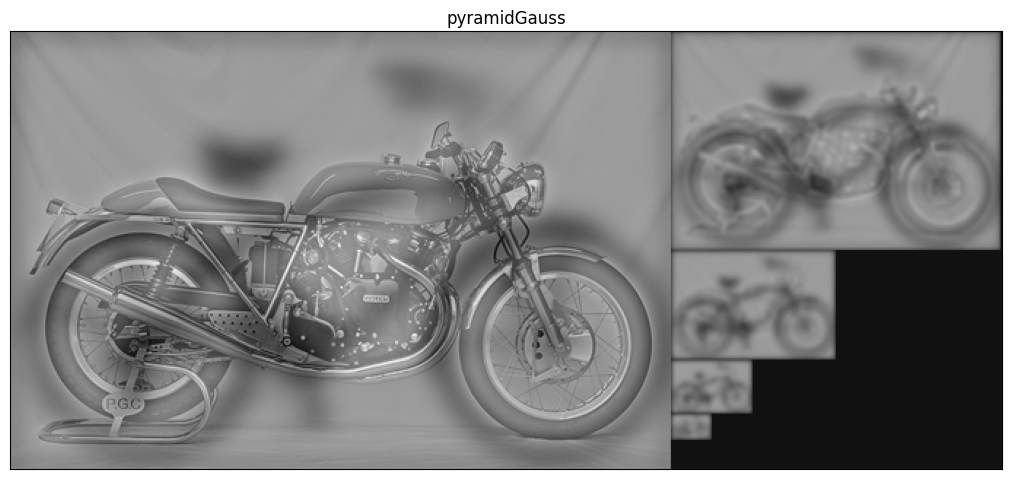

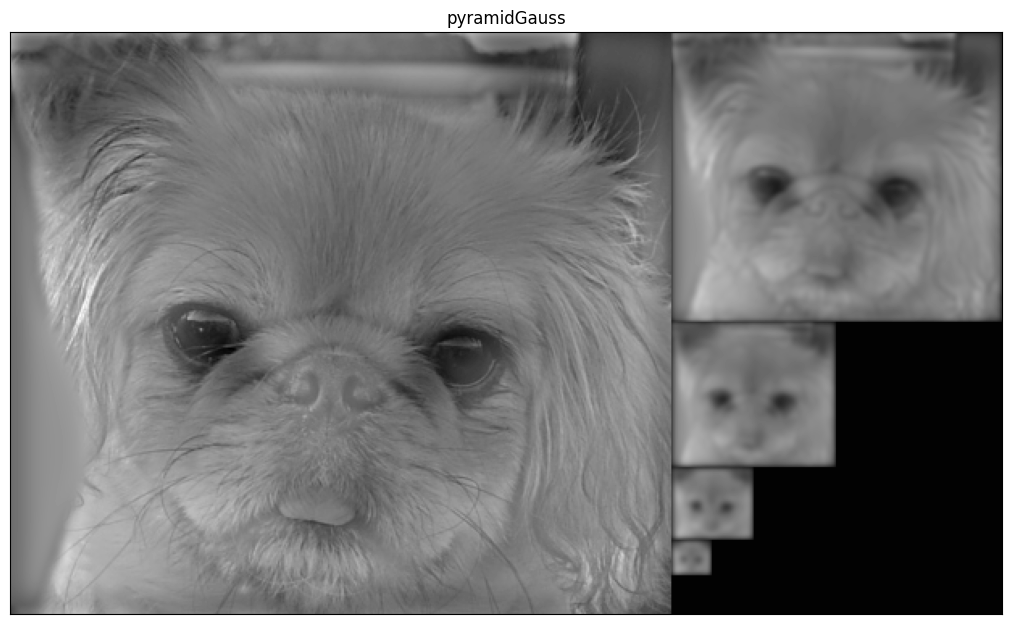

In [ ]:
#A COMPLETAR POR EL ALUMNADO
def BajaFrecuencia(imagen,sigma):
  return my2DConv(imagen,sigma,[0,0])

def GeneracionEfectoOptico (imagen1, imagen2, sigma1, sigma2):
  im1 = cv2.imread(get_image(imagen1), cv2.IMREAD_GRAYSCALE)
  im2 = cv2.imread(get_image(imagen2), cv2.IMREAD_GRAYSCALE)

  im1 = BajaFrecuencia(im1,sigma1)
  im3  = BajaFrecuencia(im2,sigma2)

  im2 = im2 - im3
  im = im1 + im2
  pyrG = pyramidGauss(im,sizeMask=7, nlevel=4)
  displayPyramid(pyrG, 'pyramidGauss')

GeneracionEfectoOptico('marilyn.bmp','einstein.bmp',4,7)
GeneracionEfectoOptico('bicycle.bmp','motorcycle.bmp',8,6)
GeneracionEfectoOptico('cat.bmp','dog.bmp',10,6)


En la Figura anterior se muestra el resultado obtenido para diferentes pares de imágenes. Como se puede observar, en la imagen más grande de la pirámide se percibe claramente la figura de Einstein. Sin embargo, a medida que se asciende en la pirámide y la imagen se reduce de tamaño, comienza a aparecer la imagen de Marilyn Monroe.